### 📌 Cell #1: Library Imports
In this step, we imported all the necessary libraries for:
- **Data manipulation & analysis** → `pandas`, `numpy`
- **Visualization** → `matplotlib`, `seaborn`, `plotly`
- **Machine Learning** → `scikit-learn` (regression models, evaluation metrics, feature selection, preprocessing)
- **Date operations & regex** → `datetime`, `re`

This ensures the environment is ready for data processing, visualization, and modeling.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
# For date operations
from datetime import datetime, timedelta
import re


### 📌 Cell #2: Data Loading & Initial Exploration
In this step:
- The dataset **`injury_dataset_extended.csv`** is loaded into a Pandas DataFrame.  
- We display:
  - The **total number of rows and columns**
  - The **first 5 rows** of the dataset
  - **Column data types and non-null counts**
  - **Statistical summary** of numerical features

This provides an overview of the dataset’s structure, contents, and initial quality.

In [2]:
# Load your CSV file (replace the filename with your own file)
df = pd.read_csv('/content/injury_dataset_extended.csv')

print("📊 General Dataset Information:")
print(f"Total number of rows: {len(df)}")
print(f"Total number of columns: {len(df.columns)}")

print("\n🔍 First 5 rows:")
print(df.head())

print("\n📋 Column information:")
print(df.info())

print("\n📈 Statistics of numerical columns:")
print(df.describe())

📊 General Dataset Information:
Total number of rows: 1346
Total number of columns: 9

🔍 First 5 rows:
  Season                  Injury        From       Until   Days GamesMissed  \
0  25/26                 Fitness  2025-07-18  2025-08-09   22.0           1   
1  24/25  Cruciate ligament tear  2024-11-07  2025-07-18  253.0          39   
2  24/25       Torn thigh muscle  2024-08-31  2024-09-20   20.0           3   
3  23/24                  bruise  2024-02-28  2024-03-02    3.0           1   
4  23/24         Eyebow fracture  2023-12-24  2024-01-19   26.0           5   

         Player  PlayerID  Weeks  
0  Mauro Icardi     68863    3.1  
1  Mauro Icardi     68863   36.1  
2  Mauro Icardi     68863    2.9  
3  Mauro Icardi     68863    0.4  
4  Mauro Icardi     68863    3.7  

📋 Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1346 entries, 0 to 1345
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  


### 📌 Cell #3: Data Cleaning Function
Here, we defined a function **`clean_injury_data()`** that:
- Creates a copy of the dataset to avoid altering the original.
- Converts **`From`** and **`Until`** columns into datetime format.
- Replaces invalid values (`'-'`) in **`Games Missed`** with `0` and ensures numeric type conversion.
- Checks and displays the number of **missing values** in each column.
- Converts selected numerical columns (`Days`, `Games Missed`, `Weeks`) to numeric types.

Finally, we applied this function to the dataset and stored the cleaned version in **`df_clean`**.


In [4]:
def clean_injury_data(df):
    df_clean = df.copy()

    # Convert date columns to datetime format
    df_clean['From'] = pd.to_datetime(df_clean['From'], errors='coerce')
    df_clean['Until'] = pd.to_datetime(df_clean['Until'], errors='coerce')

    # Replace '-' values in Games Missed column with 0
    df_clean['GamesMissed'] = df_clean['GamesMissed'].replace('-', 0)
    df_clean['GamesMissed'] = pd.to_numeric(df_clean['GamesMissed'], errors='coerce')

    # Check for missing values
    print("🔍 Missing values:")
    print(df_clean.isnull().sum())

    # Fix numeric columns
    numeric_columns = ['Days', 'GamesMissed', 'Weeks']
    for col in numeric_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    return df_clean

# Clean the data
df_clean = clean_injury_data(df)


🔍 Missing values:
Season          0
Injury          0
From            0
Until          10
Days           10
GamesMissed     1
Player          0
PlayerID        0
Weeks          10
dtype: int64


### 📌 Cell #4: Feature Engineering
In this step, we enhanced the dataset with **new features**:
- **Season_Start** → Extracted numerical season start year.
- **Injury_Category** → Classified injuries into categories: *muscle, joint, bone, virus, other*.
- **Injury_Month** → Extracted the month when the injury began.
- **Season_Period** → Determined whether the injury occurred in *Early, Mid, Late, or Off Season*.
- **Injury_Severity** → Categorized severity based on missed days: *Mild, Moderate, Severe, Very Severe*.

These engineered features will help improve insights and model performance.

In [5]:
def create_features(df):
    df_features = df.copy()

    # Convert season info to numeric
    df_features['Season_Start'] = df_features['Season'].str.split('/').str[0].astype(int) + 2000

    # Categorize injury types
    injury_categories = {
        'muscle': ['hamstring', 'adductor', 'groin', 'muscle', 'strain'],
        'joint': ['knee', 'ankle', 'shoulder', 'elbow', 'hip'],
        'bone': ['fracture', 'break', 'bone'],
        'virus': ['corona', 'virus', 'flu', 'covid'],
        'other': []
    }

    def categorize_injury(injury_text):
        injury_lower = injury_text.lower()
        for category, keywords in injury_categories.items():
            if any(keyword in injury_lower for keyword in keywords):
                return category
        return 'other'

    df_features['Injury_Category'] = df_features['Injury'].apply(categorize_injury)

    # Add the month when the injury started
    df_features['Injury_Month'] = df_features['From'].dt.month

    # Determine in which part of the season the injury occurred
    def get_season_period(month):
        if month in [8, 9, 10]:
            return 'Early_Season'
        elif month in [11, 12, 1]:
            return 'Mid_Season'
        elif month in [2, 3, 4]:
            return 'Late_Season'
        else:
            return 'Off_Season'

    df_features['Season_Period'] = df_features['Injury_Month'].apply(get_season_period)

    # Categorize injury severity (based on number of days)
    def categorize_severity(days):
        if days <= 7:
            return 'Mild'
        elif days <= 21:
            return 'Moderate'
        elif days <= 60:
            return 'Severe'
        else:
            return 'Very_Severe'

    df_features['Injury_Severity'] = df_features['Days'].apply(categorize_severity)

    return df_features

# Apply feature engineering
df_featured = create_features(df_clean)

print("🔧 New features created:")
print(df_featured[['Injury', 'Injury_Category', 'Season_Period', 'Injury_Severity']].head())

🔧 New features created:
                   Injury Injury_Category Season_Period Injury_Severity
0                 Fitness           other    Off_Season          Severe
1  Cruciate ligament tear           other    Mid_Season     Very_Severe
2       Torn thigh muscle          muscle  Early_Season        Moderate
3                  bruise           other   Late_Season            Mild
4         Eyebow fracture            bone    Mid_Season          Severe


### 📌 Cell #5: Exploratory Data Analysis (EDA)
In this step, we performed **basic exploratory analysis**:
- Displayed the **distribution of injury categories**.
- Showed the **distribution of injury severity** levels.
- Examined how injuries are spread across different **season periods**.
- Calculated the **correlation matrix** between numerical features (`Days`, `GamesMissed`, `Weeks`, `Season_Start`, `Injury_Month`).

This provides initial insights into the dataset and relationships between variables before visualization and modeling.

In [6]:
print("📊 EXPLORATORY DATA ANALYSIS")
print("="*50)

# Distribution of injury categories
print("\n🏥 Distribution of Injury Categories:")
injury_cat_counts = df_featured['Injury_Category'].value_counts()
print(injury_cat_counts)

# Distribution of injury severity
print("\n⚡ Distribution of Injury Severity:")
severity_counts = df_featured['Injury_Severity'].value_counts()
print(severity_counts)

# Distribution of season periods
print("\n📅 Distribution of Season Periods:")
season_period_counts = df_featured['Season_Period'].value_counts()
print(season_period_counts)

# Correlation of numerical variables
print("\n🔗 Correlation Between Numerical Variables:")
numeric_cols = ['Days', 'GamesMissed', 'Weeks', 'Season_Start', 'Injury_Month']
correlation_matrix = df_featured[numeric_cols].corr()
print(correlation_matrix)

📊 EXPLORATORY DATA ANALYSIS

🏥 Distribution of Injury Categories:
Injury_Category
other     565
muscle    429
joint     247
virus      83
bone       22
Name: count, dtype: int64

⚡ Distribution of Injury Severity:
Injury_Severity
Moderate       479
Mild           396
Severe         320
Very_Severe    151
Name: count, dtype: int64

📅 Distribution of Season Periods:
Season_Period
Mid_Season      418
Early_Season    411
Late_Season     347
Off_Season      170
Name: count, dtype: int64

🔗 Correlation Between Numerical Variables:
                  Days  GamesMissed     Weeks  Season_Start  Injury_Month
Days          1.000000     0.930175  0.999990      0.021907      0.059131
GamesMissed   0.930175     1.000000  0.930199      0.005933      0.089174
Weeks         0.999990     0.930199  1.000000      0.021909      0.059158
Season_Start  0.021907     0.005933  0.021909      1.000000      0.044393
Injury_Month  0.059131     0.089174  0.059158      0.044393      1.000000


### 📌 Cell #6: Data Visualization
We created **4 plots** to better understand the dataset:

1. **Histogram of injury duration** → Shows how many days injuries typically last.  
2. **Bar chart of injury categories** → Displays the frequency of different injury types (muscle, joint, bone, etc.).  
3. **Line plot of monthly injuries** → Reveals seasonal patterns in injury occurrences.  
4. **Bar chart of severity vs. average duration** → Illustrates how the average recovery time changes with severity levels (*Mild → Very Severe*).

These visualizations highlight key trends and patterns in injury data.

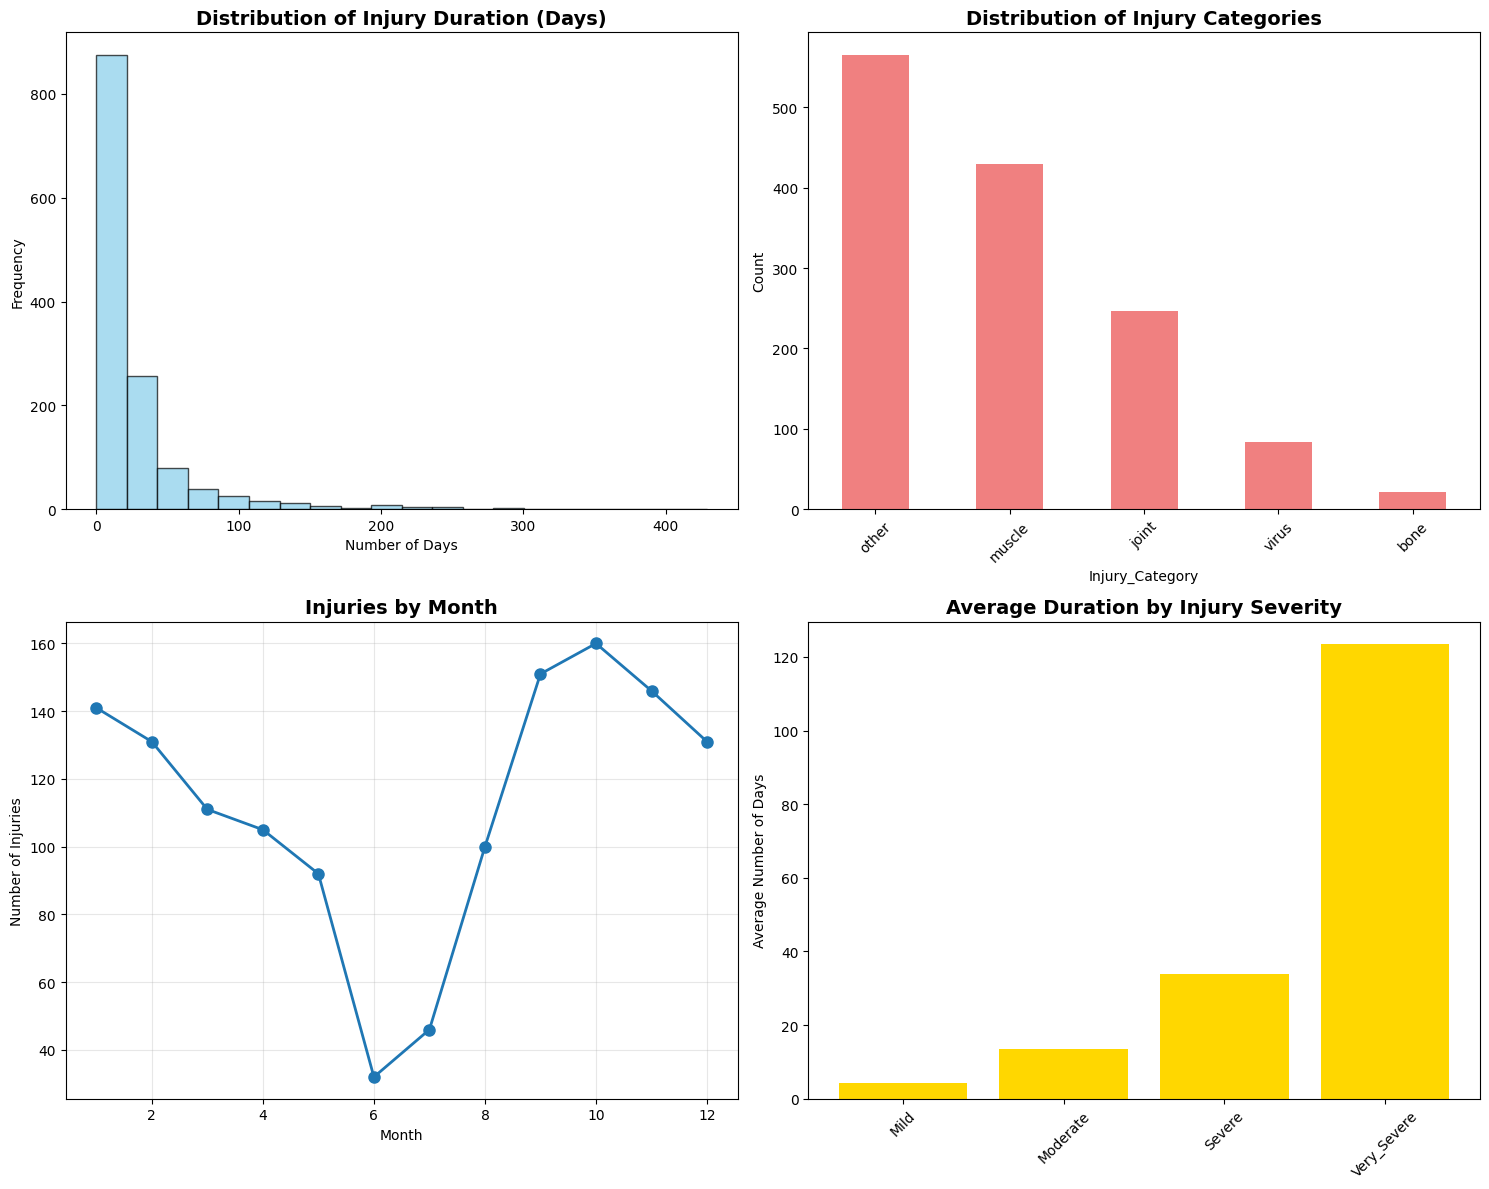

In [7]:
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution of injury duration
axes[0, 0].hist(df_featured['Days'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Injury Duration (Days)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Days')
axes[0, 0].set_ylabel('Frequency')

# 2. Distribution of injury categories
injury_cat_counts.plot(kind='bar', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Distribution of Injury Categories', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Injuries by month
monthly_injuries = df_featured['Injury_Month'].value_counts().sort_index()
axes[1, 0].plot(monthly_injuries.index, monthly_injuries.values, marker='o', linewidth=2, markersize=8)
axes[1, 0].set_title('Injuries by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of Injuries')
axes[1, 0].grid(True, alpha=0.3)

# 4. Injury severity vs duration
severity_order = ['Mild', 'Moderate', 'Severe', 'Very_Severe']
severity_days = df_featured.groupby('Injury_Severity')['Days'].mean().reindex(severity_order)
axes[1, 1].bar(severity_days.index, severity_days.values, color='gold')
axes[1, 1].set_title('Average Duration by Injury Severity', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Average Number of Days')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 📌 Cell #7: Distribution of Injury Days
We plotted a **histogram with KDE (Kernel Density Estimate)** to visualize the distribution of the `Days` variable, which represents the number of days players stayed away from the field due to injuries.

This helps identify:
- The **most common recovery durations**,
- Whether the distribution is **skewed** (e.g., more short-term vs. long-term injuries).

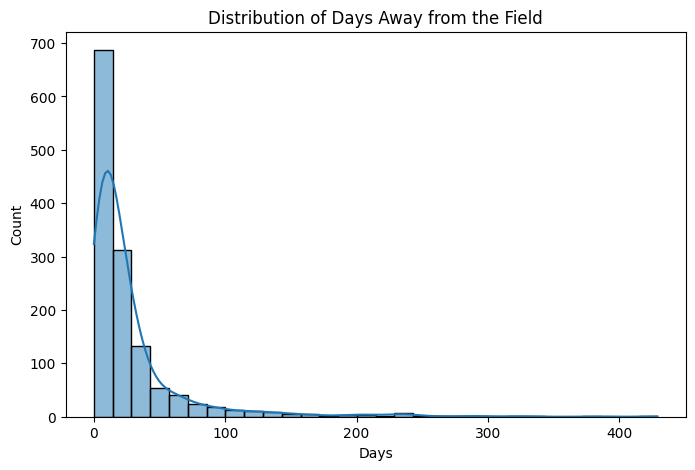

In [8]:
# Distribution of Days
plt.figure(figsize=(8,5))
sns.histplot(df["Days"], bins=30, kde=True)
plt.title("Distribution of Days Away from the Field")
plt.show()

### 📌 Cell #8: Correlation & Category Analysis
In this step, we created **two key visualizations**:

1. **Correlation Heatmap**  
   - Displays the correlations between numerical features such as `Days`, `GamesMissed`, `Weeks`, `Season_Start`, and `Injury_Month`.  
   - Helps identify which variables are strongly related (positive or negative).

2. **Box Plot by Injury Category**  
   - Shows the distribution of injury durations (`Days`) across different injury categories (*muscle, joint, bone, virus, other*).  
   - Highlights median recovery time, variability, and potential outliers in each category.

These plots provide both **statistical relationships** and **comparisons between groups** in the dataset.

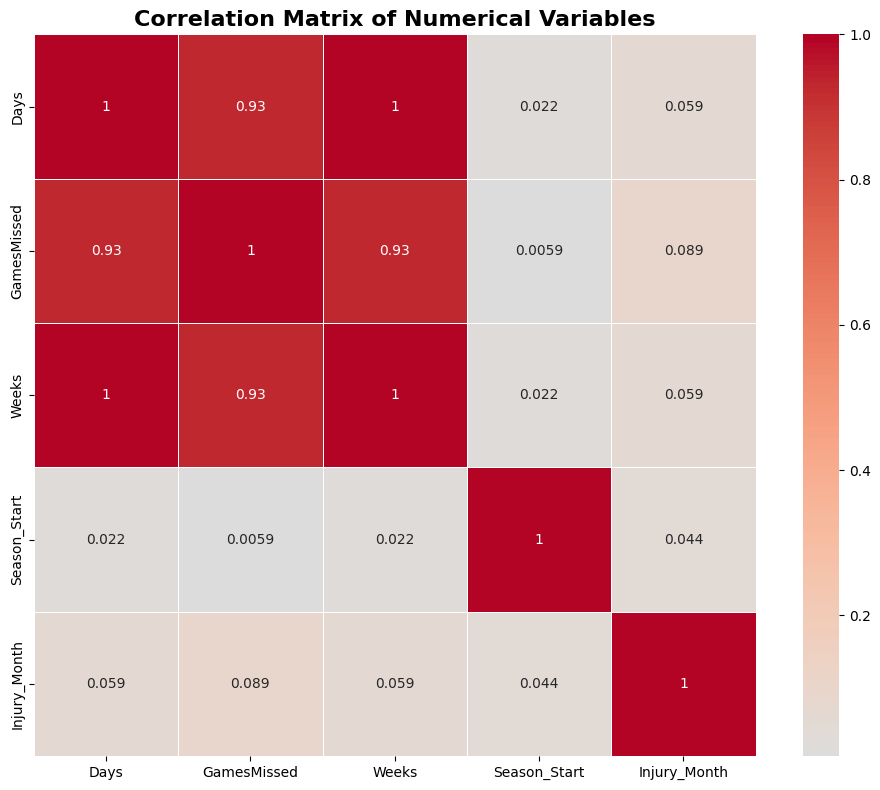

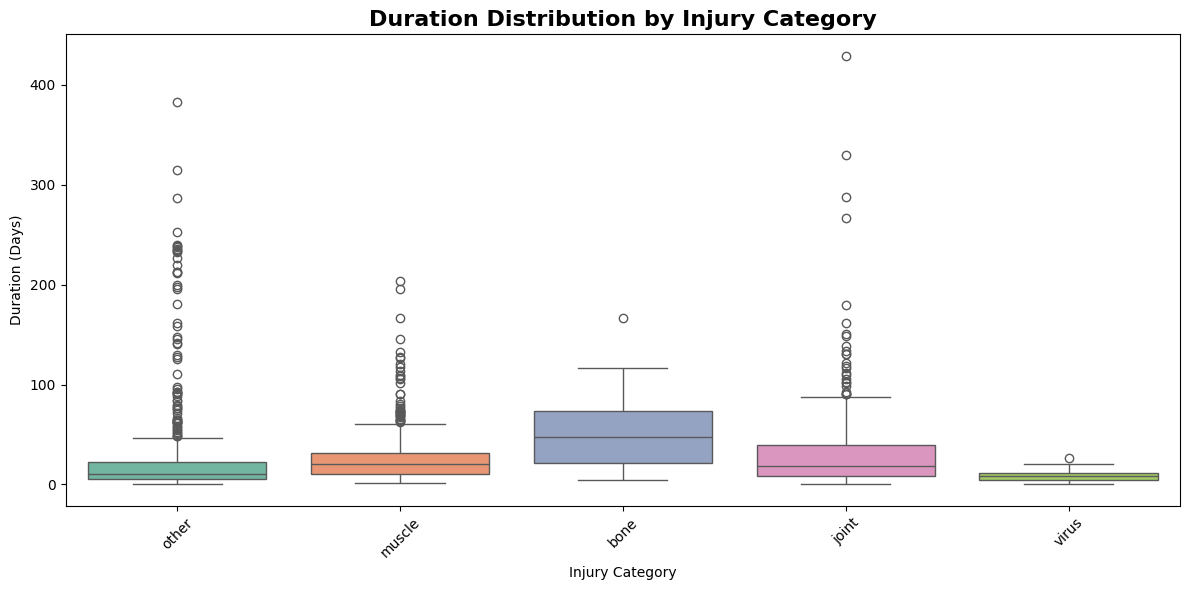

In [9]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Box plot: Duration distribution by injury category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_featured, x='Injury_Category', y='Days', palette='Set2')
plt.title('Duration Distribution by Injury Category', fontsize=16, fontweight='bold')
plt.xlabel('Injury Category')
plt.ylabel('Duration (Days)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 📌 Cell #9: Machine Learning Data Preparation
Here we prepared the dataset for machine learning:

- Applied **Label Encoding** to categorical variables:
  - `Injury`, `Injury_Category`, `Season_Period`, `Player`
- Selected **feature columns** (`X`) including categorical encodings, season info, and games missed.
- Defined **target variable** (`y`) as `Days` (recovery duration).
- Removed rows with missing values.
- Returned both the processed dataset and the trained encoders for later use.

Finally, we printed:
- Number of features
- Number of samples
- Mean and standard deviation of the target variable.

This structured data is now ready for model training.

In [10]:
def prepare_ml_data(df):
    # Encode categorical variables
    df_ml = df.copy()

    # Use label encoders
    le_injury = LabelEncoder()
    le_category = LabelEncoder()
    le_season_period = LabelEncoder()
    le_player = LabelEncoder()

    df_ml['Injury_Encoded'] = le_injury.fit_transform(df_ml['Injury'])
    df_ml['Category_Encoded'] = le_category.fit_transform(df_ml['Injury_Category'])
    df_ml['Season_Period_Encoded'] = le_season_period.fit_transform(df_ml['Season_Period'])
    df_ml['Player_Encoded'] = le_player.fit_transform(df_ml['Player'])

    # Select feature columns
    feature_columns = [
        'Injury_Encoded', 'Category_Encoded', 'Season_Period_Encoded',
        'Season_Start', 'Injury_Month', 'Player_Encoded', 'GamesMissed'
    ]

    # Remove missing values
    df_ml_clean = df_ml.dropna(subset=['Days'] + feature_columns)

    X = df_ml_clean[feature_columns]
    y = df_ml_clean['Days']

    return X, y, df_ml_clean, {
        'injury_encoder': le_injury,
        'category_encoder': le_category,
        'season_period_encoder': le_season_period,
        'player_encoder': le_player
    }

# Prepare data
X, y, df_ml, encoders = prepare_ml_data(df_featured)

print("🤖 Machine Learning Data Preparation:")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Target variable (Days) mean: {y.mean():.2f}")
print(f"Target variable std deviation: {y.std():.2f}")

🤖 Machine Learning Data Preparation:
Number of features: 7
Number of samples: 1335
Target variable (Days) mean: 27.24
Target variable std deviation: 41.97


### 📌 Cell #10: Model Training and Evaluation
In this step, we trained **multiple regression models** to predict `Days` (injury duration):

- **Models tested:**
  - Random Forest Regressor
  - Gradient Boosting Regressor
  - Linear Regression
  - Ridge Regression
  - Lasso Regression
  - Support Vector Regressor (SVR)
  
- **Process:**
  1. Split data into **training (80%)** and **test (20%)** sets.
  2. Applied **standard scaling** for models sensitive to feature scale (Linear, Ridge, Lasso, SVR).
  3. Trained each model and predicted on the test set.
  4. Calculated performance metrics:
     - RMSE (Root Mean Squared Error)
     - MAE (Mean Absolute Error)
     - R² score

- **Output:** Printed evaluation metrics for each model and stored trained models and results in a dictionary for later comparison.

In [11]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'SVR': SVR(kernel='rbf', C=1.0)
}

# Store model performance
model_results = {}

print("🔬 Model Training and Evaluation:")
print("="*50)

for name, model in models.items():
    # Use scaled data if needed
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'SVR']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test

    # Train model
    model.fit(X_train_use, y_train)

    # Predictions
    y_pred = model.predict(X_test_use)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    model_results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'model': model
    }

    print(f"\n📊 {name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.3f}")

🔬 Model Training and Evaluation:

📊 Random Forest:
  RMSE: 15.79
  MAE: 8.31
  R²: 0.862

📊 Gradient Boosting:
  RMSE: 16.64
  MAE: 8.52
  R²: 0.847

📊 Linear Regression:
  RMSE: 15.09
  MAE: 8.81
  R²: 0.874

📊 Ridge Regression:
  RMSE: 15.08
  MAE: 8.80
  R²: 0.874

📊 Lasso Regression:
  RMSE: 14.99
  MAE: 8.55
  R²: 0.876

📊 SVR:
  RMSE: 37.07
  MAE: 14.88
  R²: 0.239


### 📌 Cell #11: Best Model Selection & Feature Importance
In this step:

1. **Best model selection:**  
   - Chose the model with the **lowest RMSE** on the test set as the best-performing model.
   
2. **Performance display:**  
   - Printed **RMSE** and **R²** for the best model.

3. **Feature importance (Random Forest only):**  
   - Extracted and sorted the feature importances.
   - Displayed the top 10 most important features in a bar chart.
   
This step helps identify both the **best predictive model** and the **key factors** influencing injury duration predictions.

In [12]:
# Select the best model based on RMSE
best_model_name = min(model_results.keys(), key=lambda k: model_results[k]['RMSE'])
best_model = model_results[best_model_name]['model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"RMSE: {model_results[best_model_name]['RMSE']:.2f}")
print(f"R²: {model_results[best_model_name]['R2']:.3f}")

# Show feature importance if the best model is Random Forest
if best_model_name == 'Random Forest':
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n🔍 Feature Importances:")
    print(feature_importance)

    # Plot top 10 important features
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature', palette='viridis')
    plt.title('Top 10 Important Features', fontsize=16, fontweight='bold')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()


🏆 Best Model: Lasso Regression
RMSE: 14.99
R²: 0.876


### 📌 Cell #12: Injury Duration Prediction Function
This function allows **predicting the expected recovery duration** for a player’s injury:

- **Inputs:**
  - `injury_type`, `injury_category`, `season_period`, `season_start`, `injury_month`
  - `player_name`, `games_missed`
  - Trained `encoders`, selected `model`, and `scaler`

- **Process:**
  1. Encode categorical inputs using the pre-trained label encoders.
  2. Construct the **feature vector**.
  3. Apply scaling if the model requires it (e.g., Linear, Ridge, Lasso, SVR).
  4. Make the prediction and round to nearest integer (minimum 1 day).

- **Output:** Predicted number of days a player will be out due to the injury.

- **Example Test:**  
  Predicts recovery duration for a **Hamstring strain** for player *Anastasios Bakasetas* during mid-season with 2 games missed.

In [13]:
def predict_injury_duration(injury_type, injury_category, season_period, season_start,
                          injury_month, player_name, games_missed, encoders, model, scaler):

    try:
        # Encode categorical values
        injury_encoded = encoders['injury_encoder'].transform([injury_type])[0] if injury_type in encoders['injury_encoder'].classes_ else 0
        category_encoded = encoders['category_encoder'].transform([injury_category])[0]
        season_period_encoded = encoders['season_period_encoder'].transform([season_period])[0]
        player_encoded = encoders['player_encoder'].transform([player_name])[0] if player_name in encoders['player_encoder'].classes_ else 0

        # Create feature vector
        features = np.array([[injury_encoded, category_encoded, season_period_encoded,
                            season_start, injury_month, player_encoded, games_missed]])

        # Apply scaling if required
        if best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'SVR']:
            features = scaler.transform(features)

        # Make prediction
        prediction = model.predict(features)[0]

        return max(1, int(round(prediction)))  # At least 1 day

    except Exception as e:
        print(f"Error: {e}")
        return None

# Test prediction
test_prediction = predict_injury_duration(
    injury_type='Hamstring strain',
    injury_category='muscle',
    season_period='Mid_Season',
    season_start=2023,
    injury_month=12,
    player_name='Anastasios Bakasetas',
    games_missed=2,
    encoders=encoders,
    model=best_model,
    scaler=scaler
)

print(f"\n🔮 Test Prediction:")
print(f"Predicted recovery duration for a Hamstring strain: {test_prediction} days")



🔮 Test Prediction:
Predicted recovery duration for a Hamstring strain: 12 days


### 📌 Cell #13: Model Evaluation and Comparison
This final cell visualizes and summarizes the model performance:

1. **Actual vs Predicted Plot**  
   - Shows how closely the predicted values match the actual recovery days.
   - Red dashed line represents perfect predictions.

2. **Residual Plot**  
   - Displays the residuals (actual - predicted) against predicted values.
   - Helps detect patterns or heteroscedasticity.

3. **Model Comparison Bar Chart**  
   - Compares **RMSE** and **MAE** for all tested models.
   - Lower values indicate better predictive performance.

4. **Summary Output**  
   - Confirms the **best model** based on RMSE.
   - Reports RMSE and R² for final evaluation.

This cell provides both **visual insights** and **quantitative comparison** to finalize model selection.

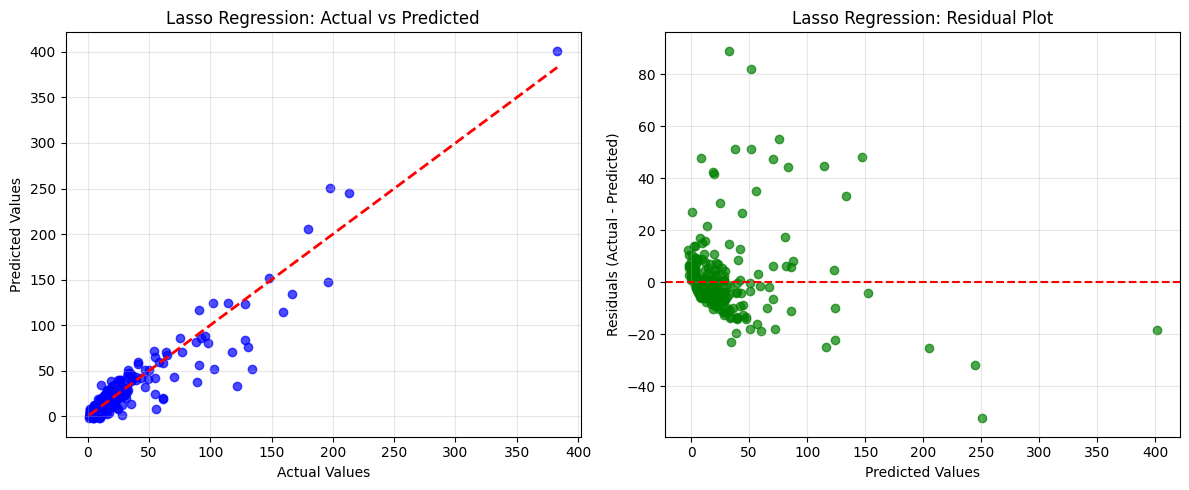

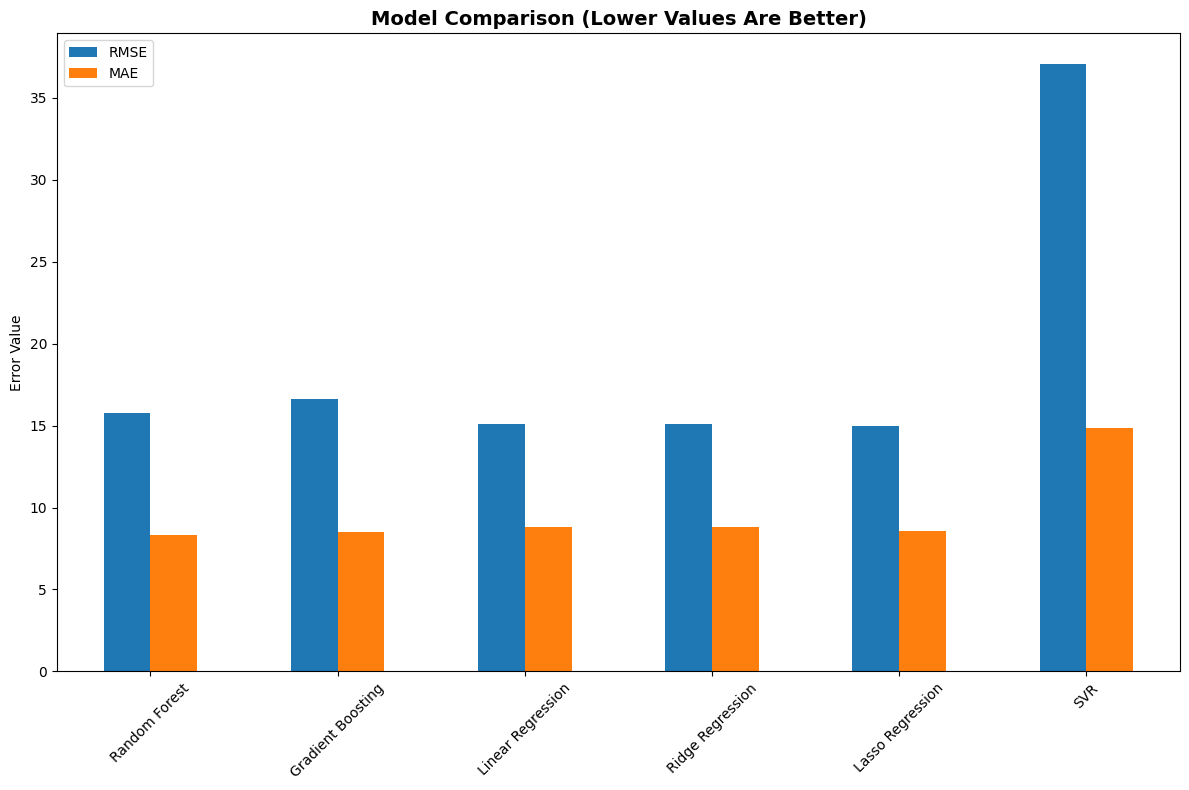


✅ Analysis completed!
📊 Best model: Lasso Regression
🎯 RMSE: 14.99 days
📈 R²: 0.876


In [15]:
# Predict using the best model
if best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'SVR']:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(12, 5))

# Subplot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_best, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'{best_model_name}: Actual vs Predicted')
plt.grid(True, alpha=0.3)

# Subplot 2: Residual plot
residuals = y_test - y_pred_best
plt.subplot(1, 2, 2)
plt.scatter(y_pred_best, residuals, alpha=0.7, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'{best_model_name}: Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare model results
results_df = pd.DataFrame(model_results).T
results_df = results_df.drop('model', axis=1)

plt.figure(figsize=(12, 8))
results_df[['RMSE', 'MAE']].plot(kind='bar', ax=plt.gca())
plt.title('Model Comparison (Lower Values Are Better)', fontsize=14, fontweight='bold')
plt.ylabel('Error Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("\n✅ Analysis completed!")
print(f"📊 Best model: {best_model_name}")
print(f"🎯 RMSE: {model_results[best_model_name]['RMSE']:.2f} days")
print(f"📈 R²: {model_results[best_model_name]['R2']:.3f}")
